# Entanglement Accelerates Quantum Simulation 

This notebook demonstrates how to reproduce the key numerical result from [*Entanglement Accelerates Quantum Simulation*](https://www.nature.com/articles/s41567-025-02945-2) using NVIDIA CUDA-Q. We follow the workflow presented in the paper for the quantum Ising model with mixed fields (QIMF) and show how entanglement growth can *reduce* the observed Trotter error of the first-order product formula (PF1).

Notebook prepared by Jonah So (jonahso@ucsb.edu) and Jue Xu (xujue@connect.hku.hk).

In [1]:
# Relevant imports

import cudaq
import numpy as np
import cupy as cp
from cupyx.scipy.linalg import expm
import time, sys
from cudaq import spin
from cudaq import State
import matplotlib.pyplot as plt
from typing import List

print(cudaq.__version__)
cudaq.set_target("nvidia")

CUDA-Q Version  (https://github.com/NVIDIA/cuda-quantum e50d28149779ca5a9c6757c8a93c670aa1febfc6)


## 2. Model Definition

We focus on the $n$-qubit quantum Ising model with mixed fields (QIMF), the same Hamiltonian used throughout the paper. The subsections below walk through the exact construction, the PF1 Trotter step, and the helper routines needed for later analysis.

### 2.1 Initial product state
We start from the $|0000\ldots\rangle$ state, matching the initial condition explored in the paper. The helper kernel below prepares this state.


In [2]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    '''
    Create initial state |0000...> for n_spins
    ''' 
    qubits = cudaq.qvector(n_spins)

### 2.2 QIMF Hamiltonian

The paper studies rapid entanglement growth in the one-dimensional QIMF Hamiltonian

$$
H = h_x \sum_{j=1}^N X_j + h_y \sum_{j=1}^N Y_j + J \sum_{j=1}^{N-1} X_j X_{j+1},
$$

where $h_x$ and $h_y$ set the mixed fields and $J$ couples nearest neighbours. Every term is expressed in the Pauli basis, so we can assemble $H$ with CUDA-Q’s `spin` helpers. For later Trotterization we split the Hamiltonian into two commuting groups where the terms in the same group commute with each other:

- $A = h_x \sum_j X_j + J \sum_j X_j X_{j+1}$
- $B = h_y \sum_j Y_j$

The function below returns $(A, B, H)$

In [3]:
def create_hamiltonian_qimf(n_spins: int, J: float, h_x: float, h_y: float):

    A = 0
    B = 0
    
    for j in range(n_spins - 1):
        A += J * spin.x(j) * spin.x(j + 1)

    for j in range(n_spins):
        A += h_x * spin.x(j)
        B += h_y * spin.y(j)
        
    H = A + B

    return A, B, H

### 2.3 First-Order Trotter Formula (PF1)

The paper benchmarks the first-order product formula as a baseline algorithm. For a Hamiltonian decomposition $H = \sum_l H_l$, the ideal evolution $U(\delta t) = e^{-i H \delta t}$ is approximated by the ordered product of exponentials
$$
\mathscr{U}_1(\delta t) = \overrightarrow{\prod_{l}} e^{-i H_l \, \delta t},
$$
which incurs an error of $\mathcal{O}(\delta t^2)$ whenever the terms fail to commute. 
The authors show that once the simulated state has significant entanglement, the empirical PF1 error drops sharply to the average-case performance.

The CUDA-Q kernel below implements a single PF1 step for two commuting groups (the $A$ and $B$ partitions defined above). 

### 2.4 PF1 step for the QIMF partition

Because each $A$ term commutes with every other $A$ term (and similarly for $B$), the PF1 update factorises neatly into
$$
\mathscr{U}_1(\delta t) = e^{-i A \delta t} \, e^{-i B \delta t}.
$$
To simulate for a total time $t$, we apply this kernel $r$ times with $\delta t = t/r$. The paper sets $t=10$ and $r=100$, which we adopt below so the numerical values line up with Figure 1a.

In [4]:
@cudaq.kernel
def trotter_step_pf1 (state: cudaq.State, dt: float, c_a: List[complex], 
                      c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    '''
    The following kernel performs one trotter step for a Hamiltonian, split into two non-commuting parts.  
    Each represented by: 
    c_a, c_b: List[complex] 
        a set of coefficients corresponding to the Pauli terms 
    words_a, words_b: List[complex]
        a list of Pauli words specifying the operators
    '''
    
    qubits = cudaq.qvector(state)

    for i in range(len(c_a)):
        exp_pauli(-c_a[i].real * dt, qubits, words_a[i])

    for i in range(len(c_b)):
        exp_pauli(-c_b[i].real * dt, qubits, words_b[i])


### 2.5 Hamiltonian helpers

The simulation loop expects explicit coefficient lists and Pauli words. The utility functions below wrap CUDA-Q’s iterator API so that kernels can consume plain Python lists. This also keeps the PF1 kernel agnostic to the specific model — any Hamiltonian decomposed into commuting partitions can reuse the same workflow.


In [5]:
'''
Here, we extract coefficients and words from Hamiltonian for decomposition.
'''
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.evaluate_coefficient())
        # print(term.evaluate_coefficient)
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

## 3. Entanglement metrics

To match the paper we track how much entanglement each subsystem grows during time evolution. For a pure state $|\psi\rangle$, the reduced density matrix of a kept subsystem $A$ is
$$
\rho_A = \operatorname{Tr}_B (|\psi\rangle\langle\psi|),
$$
where $B$ denotes the qubits we trace out. The von Neumann entropy
$$
S(\rho_A) = - \sum_i \lambda_i \log_2 \lambda_i
$$
with eigenvalues $\lambda_i$ provides a convenient single-number entanglement measure. When $S(\rho_A)$ approaches its maximum the subsystem is almost maximally mixed, signalling strong entanglement with the rest of the chain. The helpers below implement the partial trace and entropy evaluation using CuPy.

In [6]:
def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    '''
    The following function computes the reduced density matrix for a pure state of an n-qubit system. 
    psi: cp.ndarray 
        The full statevector of the system 
    keep: List[int] 
        The list of qubit indices to "keep" (subsystem A). The rest of the qubits will be traced out (sybsystem B). 
    n_qubits: int 
        The number of qubits 
    ''' 
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    
    return rho_A

In [7]:
def entropy(rho: cp.ndarray) -> float:
    '''
    The following function calculates the entropy of a given density matrix: 
    rho: cp.ndarray
    ''' 
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    entropy = -cp.sum(eigvals * cp.log2(eigvals))
    return entropy.get() 

## 4. Simulation workflow

With the building blocks in place, we compare the ideal evolution with the PF1 approximation for a 12-qubit chain. The helpers below construct the exact unitary $U = e^{-iH\delta t}$ and step both trajectories forward so that we can track their divergence and the associated entanglement.


In [8]:
def ideal_U (H: cudaq.SpinOperator, dt: float) -> cp.ndarray:
    '''
    This function constructs the exact unitary time-evolution operator U = exp(-i*H*dt), given
        H: cudaq.SpinOperator 
            The Hamiltonian operator 
        dt: float
    '''
    Hm = cp.asarray(H.to_matrix())
    return expm(-1j * Hm * dt)

def ideal_next_state(U: cp.ndarray, state: cp.ndarray) -> cp.ndarray:
    '''
    The following function apply the exact unitary time-evolution operator U to the current state. 
        U: cp.ndarray
            Unitary time-evolution operator
        state: cp.ndarray 
            Current quantum state 
    ''' 
    return U @ state

### 4.1 Single-step Trotter error
Following Eq. (3) of the paper we evaluate the norm difference between the ideal state and its PF1 counterpart after each segment:
$$
\epsilon(t) = \big\|(U(\delta t) - \mathscr{U}_1(\delta t))\,|\psi(t)\rangle\big\|.
$$
Tracking $\epsilon(t)$ alongside entanglement lets us reproduce the result highlighted in Figure 1a.

In [9]:
def trotter_error(psi_ideal, psi_trot):
    return ((cp.linalg.norm(psi_ideal - psi_trot)))

### 4.2 Dual trajectory update

The driver below advances both trajectories for $r$ steps:

- **Ideal evolution** multiplies the state by $U = e^{-iH\delta t}$ at each step.
- **PF1 evolution** applies the Trotter evolution $e^{-iA\delta t}e^{-iB\delta t}$ to the CUDA-Q state.

Storing the intermediate states allows us to probe entanglement and Trotter error at every segment boundary, exactly as in the reference study.

In [ ]:
def ideal_simulation (n_spins: int, initial_state: cudaq.State, r: int, h_x_val: float, h_y_val: float, J_val: float):   
    ideal_state = initial_state
    t_state = initial_state

    out_list_ideal = []
    out_list_trotter = []

    time_list = []

    # dt is set as 0.1, as indicated in the paper 
    dt = 0.1
    
    # prepare hamiltonian for evolution 
    A, B, H = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
    c_a = extractCoefficients(A)
    c_b = extractCoefficients(B)
    words_a = extractWords(A)
    words_b = extractWords(B)
    
    start_time = time.time()

    U = ideal_U(H, dt) 
    psi_ideal = cp.asarray(ideal_state, dtype=cp.complex128) 
    
    for step in range(1, r + 1):
        psi_ideal = ideal_next_state(U, psi_ideal)
        t_state = cudaq.StateMemoryView(cudaq.get_state(trotter_step_pf1, t_state, dt, c_a, c_b, words_a, words_b))
        
        psi_t = cp.asarray(t_state, dtype=cp.complex128) 

        out_list_ideal.append(psi_ideal)
        out_list_trotter.append(psi_t)
        time_list.append(dt * step)
        
        # Compare trotter at one step 
        t_state = cudaq.State.from_data(cp.asnumpy(psi_ideal))
    
    total_time = time.time() - start_time
    print(f"Simulation done in {total_time:.2f} seconds")

    return out_list_ideal, out_list_trotter 

## 5. Reproducing the paper’s Figure 1a

We now evolve the $n=12$ QIMF chain for $t=10$ with $r=100$ PF1 steps, exactly matching the parameters in the paper. At every segment we store the PF1 error $\epsilon(t)$ and the entanglement entropy for contiguous subsystems of size 1 through 4.

In [ ]:
# Expect ~4 seconds on an NVIDIA A100 GPU (dense ideal evolution dominates runtime).
cudaq.set_target("qpp-cpu")

n = 12  # system size, number of qubits
r = 100  # number of PF1 Trotter steps

# initial state 
initial_state = cudaq.StateMemoryView(cudaq.get_state(get_initial_state, n))

# field strength and coupling strength 
h_x_val, h_y_val, J_val = 0.8090, 0.9045, 1

# the simulation returns a collection of states from computing ideal and trotter evolutions 
ideal, trotter = ideal_simulation(n, initial_state, r, h_x_val, h_y_val, J_val)

tro_error = []
# compute trotter error by comparing the two states at each step
for i in range(r): 
    tro = trotter_error(ideal[i], trotter[i])
    tro_error.append(tro.get()) 

# calculate entanglement entropy for the ideal trajectory at each step
entropy_list = []
for i in range(r):
    rdm1 = partial_trace(ideal[i], list(range(1)), n_qubits=n)
    rdm2 = partial_trace(ideal[i], list(range(2)), n_qubits=n)
    rdm3 = partial_trace(ideal[i], list(range(3)), n_qubits=n)
    rdm4 = partial_trace(ideal[i], list(range(4)), n_qubits=n)

    temp = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    entropy_list.append(temp)

Simulation done in 14.51 seconds


### 5.1 Visualising the joint behaviour

The plot below overlays the PF1 Trotter error with the entropy of increasingly large contiguous subsystems. This reproduces the qualitative behaviour of Figure 1a from [*Entanglement Accelerates Quantum Simulation*](https://www.nature.com/articles/s41567-025-02945-2):

- the PF1 error (blue) drops within the first few units of simulated time,
- each entropy curve (coloured) rises toward the maximally mixed value for its subsystem size, and
- larger subsystems take longer to saturate, mirroring the light-cone spreading of entanglement.

The key takeaway is that higher entanglement correlates with *lower* observed Trotter error, counter to the classical intuition that entanglement makes simulation harder.

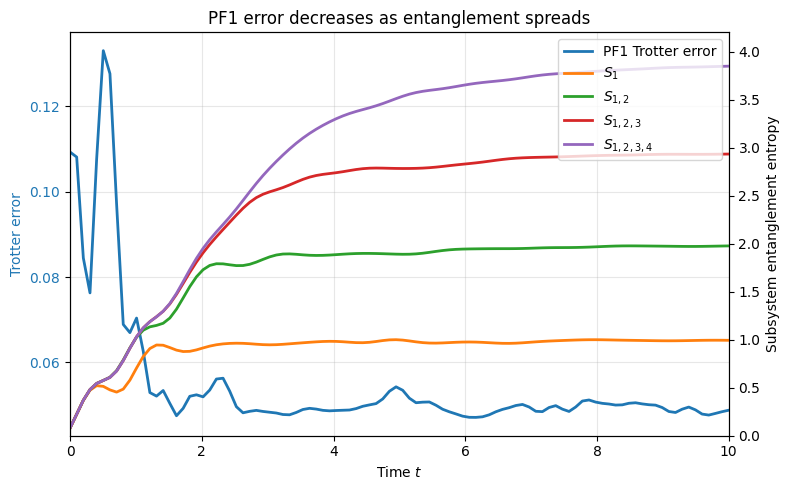

In [12]:
times = np.linspace(0, 10, r)

entropy_values = [
    [step[k] for step in entropy_list]
    for k in range(4)
]
labels = [r"$S_{1}$", r"$S_{1,2}$", r"$S_{1,2,3}$", r"$S_{1,2,3,4}$"]
colors = ["tab:orange", "tab:green", "tab:red", "tab:purple"]

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# PF1 error trend (left axis)
err_line = ax1.plot(times, tro_error, color="tab:blue", label="PF1 Trotter error", linewidth=2)
ax1.set_ylabel("Trotter error", color="tab:blue")
ax1.set_xlabel("Time $t$")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xlim(0, 10)
ax1.grid(alpha=0.3)

# Entropy growth (right axis)
entropy_lines = []
for vals, label, color in zip(entropy_values, labels, colors):
    line = ax2.plot(times, vals, label=label, color=color, linewidth=2)
    entropy_lines.extend(line)

ax2.set_ylabel("Subsystem entanglement entropy")
ax2.set_ylim(0, 4.2)
ax2.tick_params(axis="y")

# Combined legend
lines = err_line + entropy_lines
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc="upper right")

ax1.set_title("PF1 error decreases as entanglement spreads")
fig.tight_layout()

### 5.2 Interpreting the result

Intuitively, the entangled state locally looks like an ensemble of random states, leading to average-case Trotter errors that shrink as entanglement increases. 
The tutorial demonstrates that CUDA-Q can capture this effect faithfully for realistic system sizes. Try experimenting with:

- different subsystem cuts to probe entanglement propagation in more detail,
- higher-order product formulas (PF2, PF4) to compare error scalings, or
- alternative initial product states to see how quickly the system enters the high-entanglement regime.


## 6. References and further reading
- [Entanglement Accelerates Quantum Simulation](https://arxiv.org/abs/2406.02379)
- [Spin-Hamiltonian Simulation Using CUDA-Q](https://nvidia.github.io/cuda-quantum/latest/applications/python/hamiltonian_simulation.html)
